In [96]:
import os
import cv2
import numpy as np
from skimage.morphology import skeletonize

from PIL import Image
import matplotlib.pyplot as plt

In [15]:
def show(image, ax=None, title=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.imshow(image, cmap='gray')
    ax.set_axis_off()

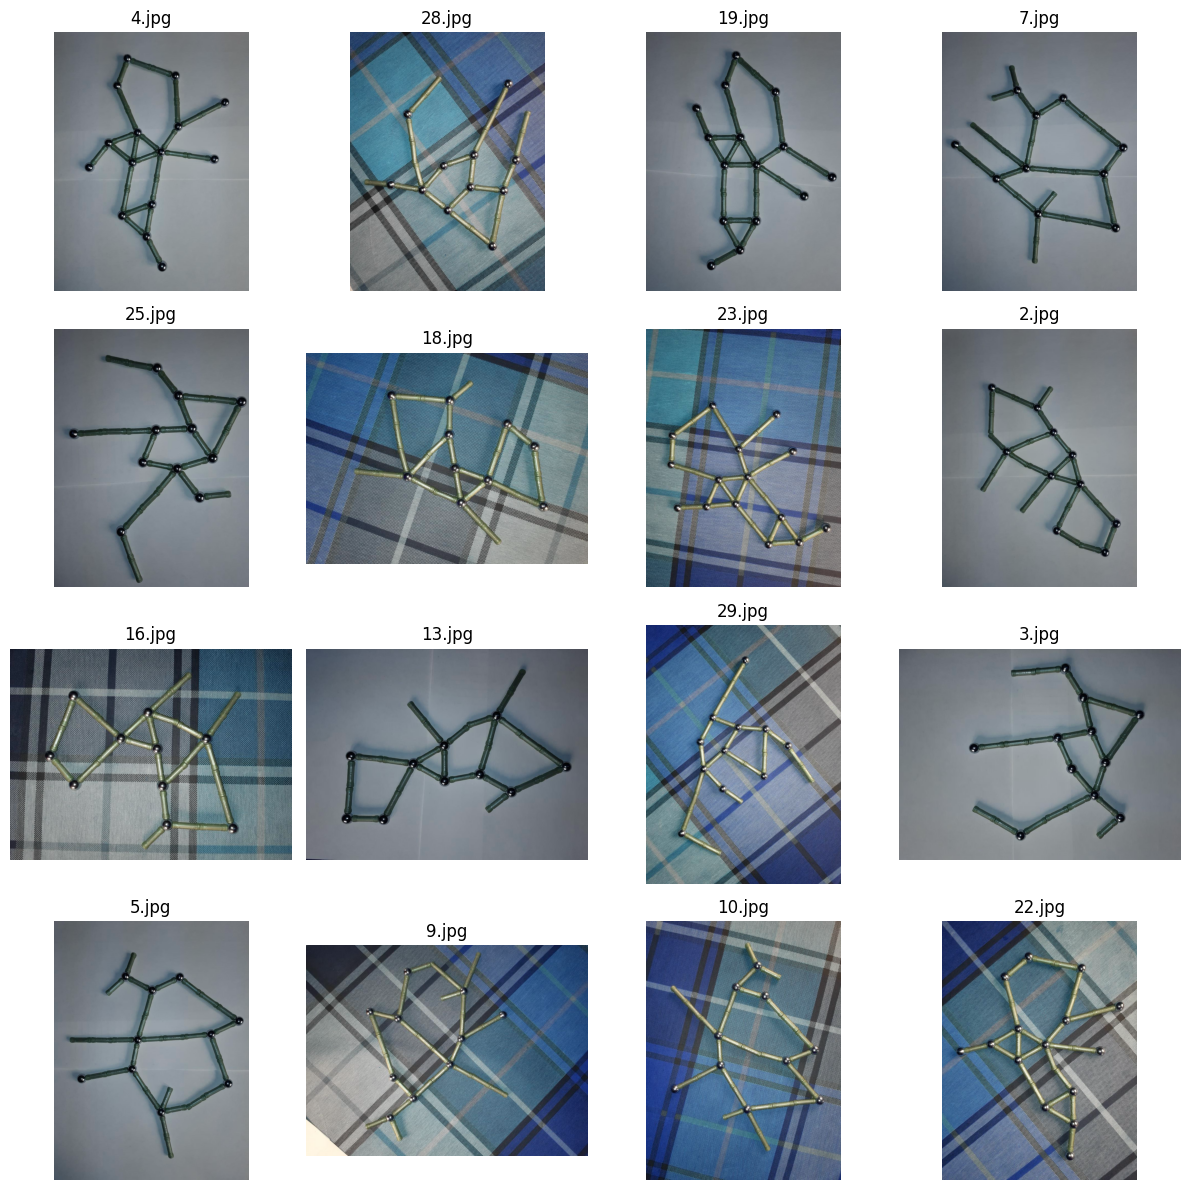

In [16]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = iter(axes.flatten())

for img, ax in zip(os.listdir('./images'), axes):
    show(cv2.imread('./images/' + img), ax=ax, title=img)
plt.tight_layout()
plt.show()

In [4]:
os.listdir('./images')

['4.jpg',
 '28.jpg',
 '19.jpg',
 '7.jpg',
 '25.jpg',
 '18.jpg',
 '23.jpg',
 '2.jpg',
 '16.jpg',
 '13.jpg',
 '29.jpg',
 '3.jpg',
 '5.jpg',
 '9.jpg',
 '10.jpg',
 '22.jpg']

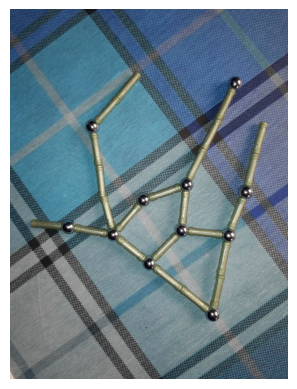

In [83]:
image = cv2.imread('./images/28.jpg')
show(image)

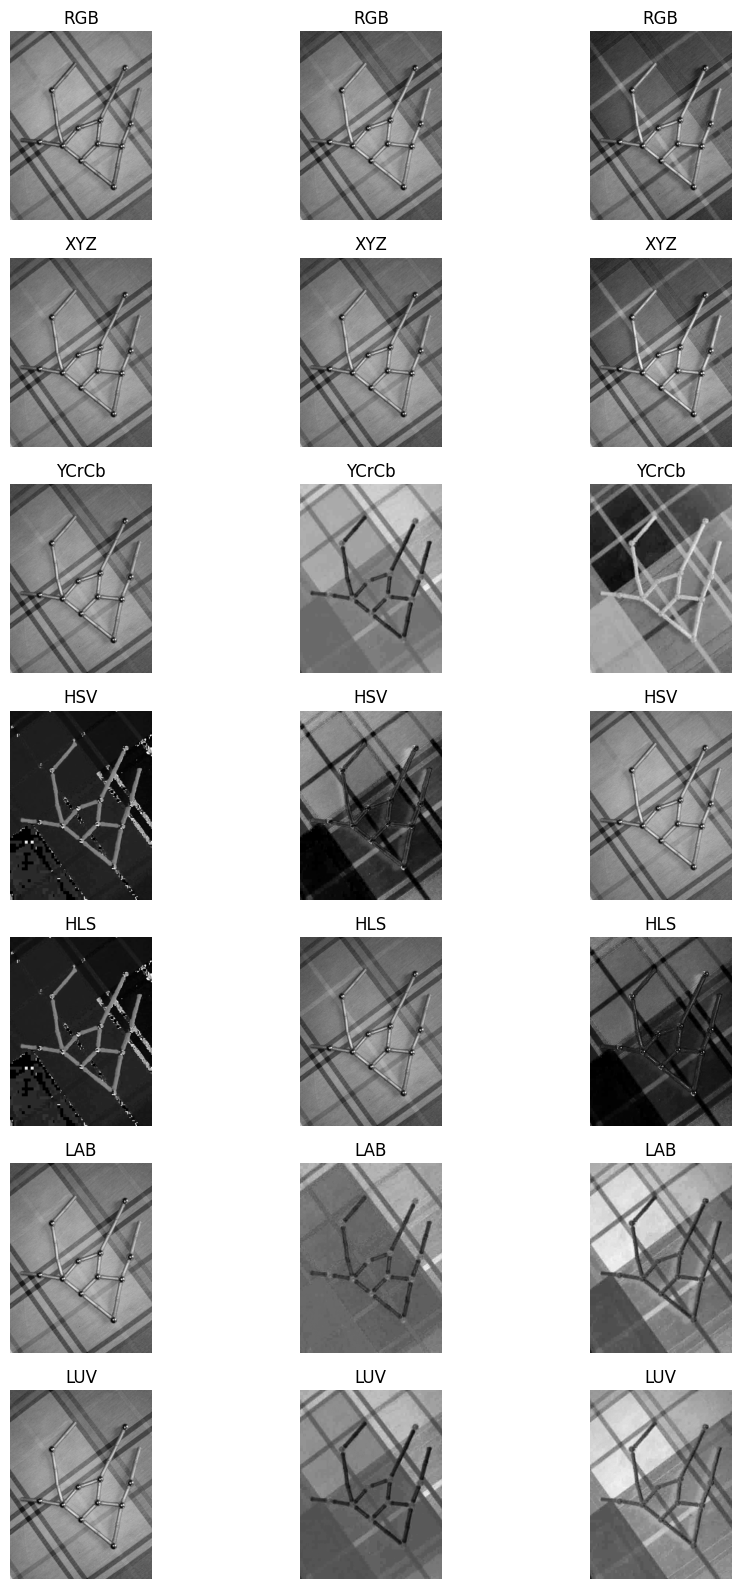

In [126]:
color_formats = {'RGB': cv2.COLOR_BGR2RGB,
                 'XYZ': cv2.COLOR_BGR2XYZ,
                 'YCrCb': cv2.COLOR_BGR2YCrCb,
                 'HSV': cv2.COLOR_BGR2HSV,
                 'HLS': cv2.COLOR_BGR2HLS,
                 'LAB': cv2.COLOR_BGR2LAB,
                 'LUV': cv2.COLOR_BGR2LUV}
fig, ax = plt.subplots(len(color_formats), 3, figsize=(10, 16))

for i, (name, fmt) in enumerate(color_formats.items()):
    img_fmt = cv2.cvtColor(image, fmt)
    for j, lyr in enumerate(cv2.split(img_fmt)):
        show(lyr, ax=ax[i][j], title=f'{name}')
plt.tight_layout()
plt.show()

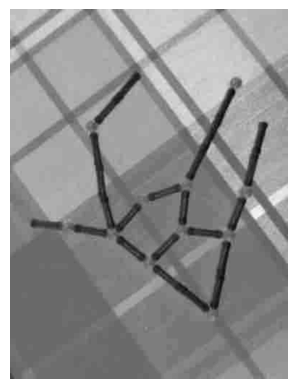

In [129]:
img_fmt = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
lyr = cv2.split(img_fmt)
show(lyr[1])
# show(lyr[2])
# lyr = (0.7 * lyr[1].astype(int) + 0.3 * (255 - lyr[2].astype(int))).astype(np.uint8)
# show(lyr)

In [537]:
def binearize_image(image):
    # remove noise
    image = cv2.GaussianBlur(image, (9, 9), 0)
    image = cv2.medianBlur(image, 15)

    # binearization
    _, image = cv2.threshold(image, 123, 255, cv2.THRESH_BINARY_INV)

    # post-processing
    image = cv2.dilate(image, (3, 3), iterations=4)
    image = cv2.morphologyEx(image, cv2.MORPH_OPEN, (9, 9), iterations=15)
    return image

In [638]:
def extend_line(pts, extension_length):
    pt1, pt2 = pts[0][0], pts[1][0]
    line_vector = pt2 - pt1
    line_length = np.linalg.norm(line_vector)
    unit_vector = line_vector / line_length
    d = (unit_vector * extension_length).astype(np.int32)

    pt1 -= d
    pt2 += d

    return np.array([[pt1], [pt2]])

In [639]:
def detect_lines(image, **kwargs):
    """
    image: np.uint8 array of shape (width, height)
    """
    lines = cv2.HoughLinesP(image, 1, np.pi / 180, **kwargs)
    processed_image = np.zeros_like(image)
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(processed_image, (x1, y1), (x2, y2), color=1, thickness=1)
    return processed_image

In [642]:
def approximate_lines(image, curvature_thres=0.05, extension_length=5):
    """
    image: np.uint8 array of shape (width, height)
    """
    processed_image = np.zeros_like(image)
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    approx = []
    for contour in contours:
        epsilon = curvature_thres * cv2.arcLength(contour, True)
        appr = cv2.approxPolyDP(contour, epsilon, True)
        appr_extended = extend_line(appr, extension_length=extension_length)
        approx.append(appr_extended)
    cv2.polylines(processed_image, approx, isClosed=False, color=1, thickness=1)
    return processed_image, approx

In [668]:
def intersects(line1, line2):
    # Unpack the line segments
    (x1, y1), (x2, y2) = line1[0][0], line1[1][0]
    (x3, y3), (x4, y4) = line2[0][0], line2[1][0]

    # Line1 represented as a1x + b1y = c1
    a1 = y2 - y1
    b1 = x1 - x2
    c1 = a1 * x1 + b1 * y1

    # Line2 represented as a2x + b2y = c2
    a2 = y4 - y3
    b2 = x3 - x4
    c2 = a2 * x3 + b2 * y3

    determinant = a1 * b2 - a2 * b1

    if determinant == 0:
        # Lines are parallel
        return None
    else:
        # Intersection point
        intersect_x = (b2 * c1 - b1 * c2) / determinant
        intersect_y = (a1 * c2 - a2 * c1) / determinant

        # Check if the intersection point is within both line segments
        if (min(x1, x2) <= intersect_x <= max(x1, x2) and
            min(y1, y2) <= intersect_y <= max(y1, y2) and
            min(x3, x4) <= intersect_x <= max(x3, x4) and
            min(y3, y4) <= intersect_y <= max(y3, y4)):
            return (intersect_x, intersect_y)
        else:
            return None

In [735]:
def build_adjacency_matrix(image):
    image, approx = approximate_lines(image, extension_length=40)
    show(image)
    output_image = np.zeros((*image.shape, 3))

    adj_matrix = np.zeros((len(approx), ) * 2, dtype=bool)
    for i in range(len(approx)):
        for j in range(i + 1, len(approx)):
            if intersects(approx[i], approx[j]):
                pt = intersects(approx[i], approx[j])
                output_image[int(pt[1]) - 3:int(pt[1]) + 3, int(pt[0]) - 3:int(pt[0]) + 3, 1] = 255

                adj_matrix[i][j] = adj_matrix[j][i] = 1
    show(output_image)
    return adj_matrix

In [736]:
def processing_step(image, extension_length=5):
    image = detect_lines(image, threshold=20, minLineLength=40, maxLineGap=30)
    image, _ = approximate_lines(image, curvature_thres=0.05, extension_length=extension_length)
    return image

In [737]:
def preprocess_image(image_orig, image, steps=3):
    # clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(30, 30))
    # image = clahe.apply(image)

    show(image)
    image = binearize_image(image)
    show(image)

    image = skeletonize(image).astype(np.uint8)
    show(image)

    ext = [5, 5, 5]  # extensions
    for i in range(steps):
        image = processing_step(image, ext[i])
    show(image)

    adj_matrix = build_adjacency_matrix(image)
    features = np.bincount(adj_matrix.sum(axis=1))
    return features, adj_matrix

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


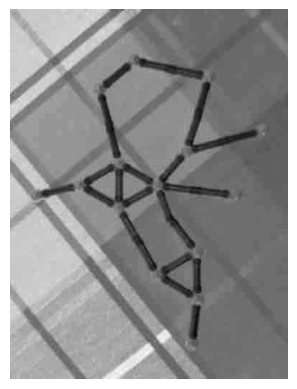

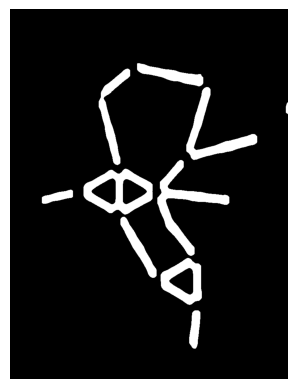

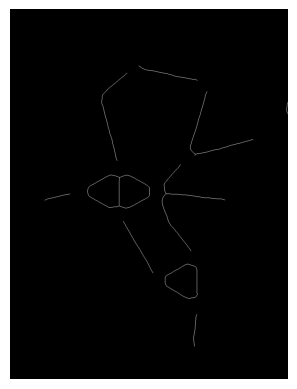

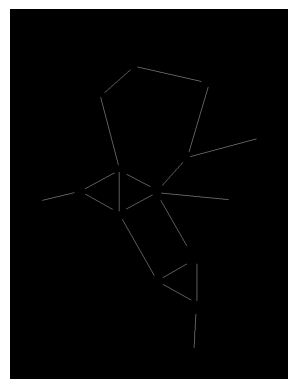

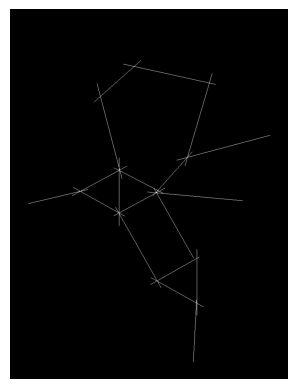

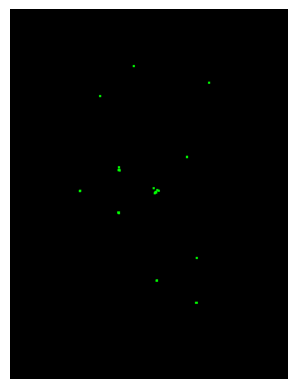

In [738]:
image = cv2.imread('./images/22.jpg')
img_fmt = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
lyr = cv2.split(img_fmt)
features, adj_matrix = preprocess_image(image, lyr[1])

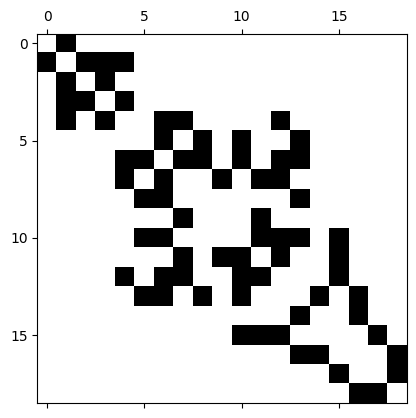

In [742]:
plt.spy(adj_matrix)
plt.show()

In [722]:
colored_idxs = (28, 18, 23, 16, 29, 9, 10, 22)
' '.join([idx[:-4] for idx in os.listdir('./images')])

'4 28 19 7 25 18 23 2 16 13 29 3 5 9 10 22'

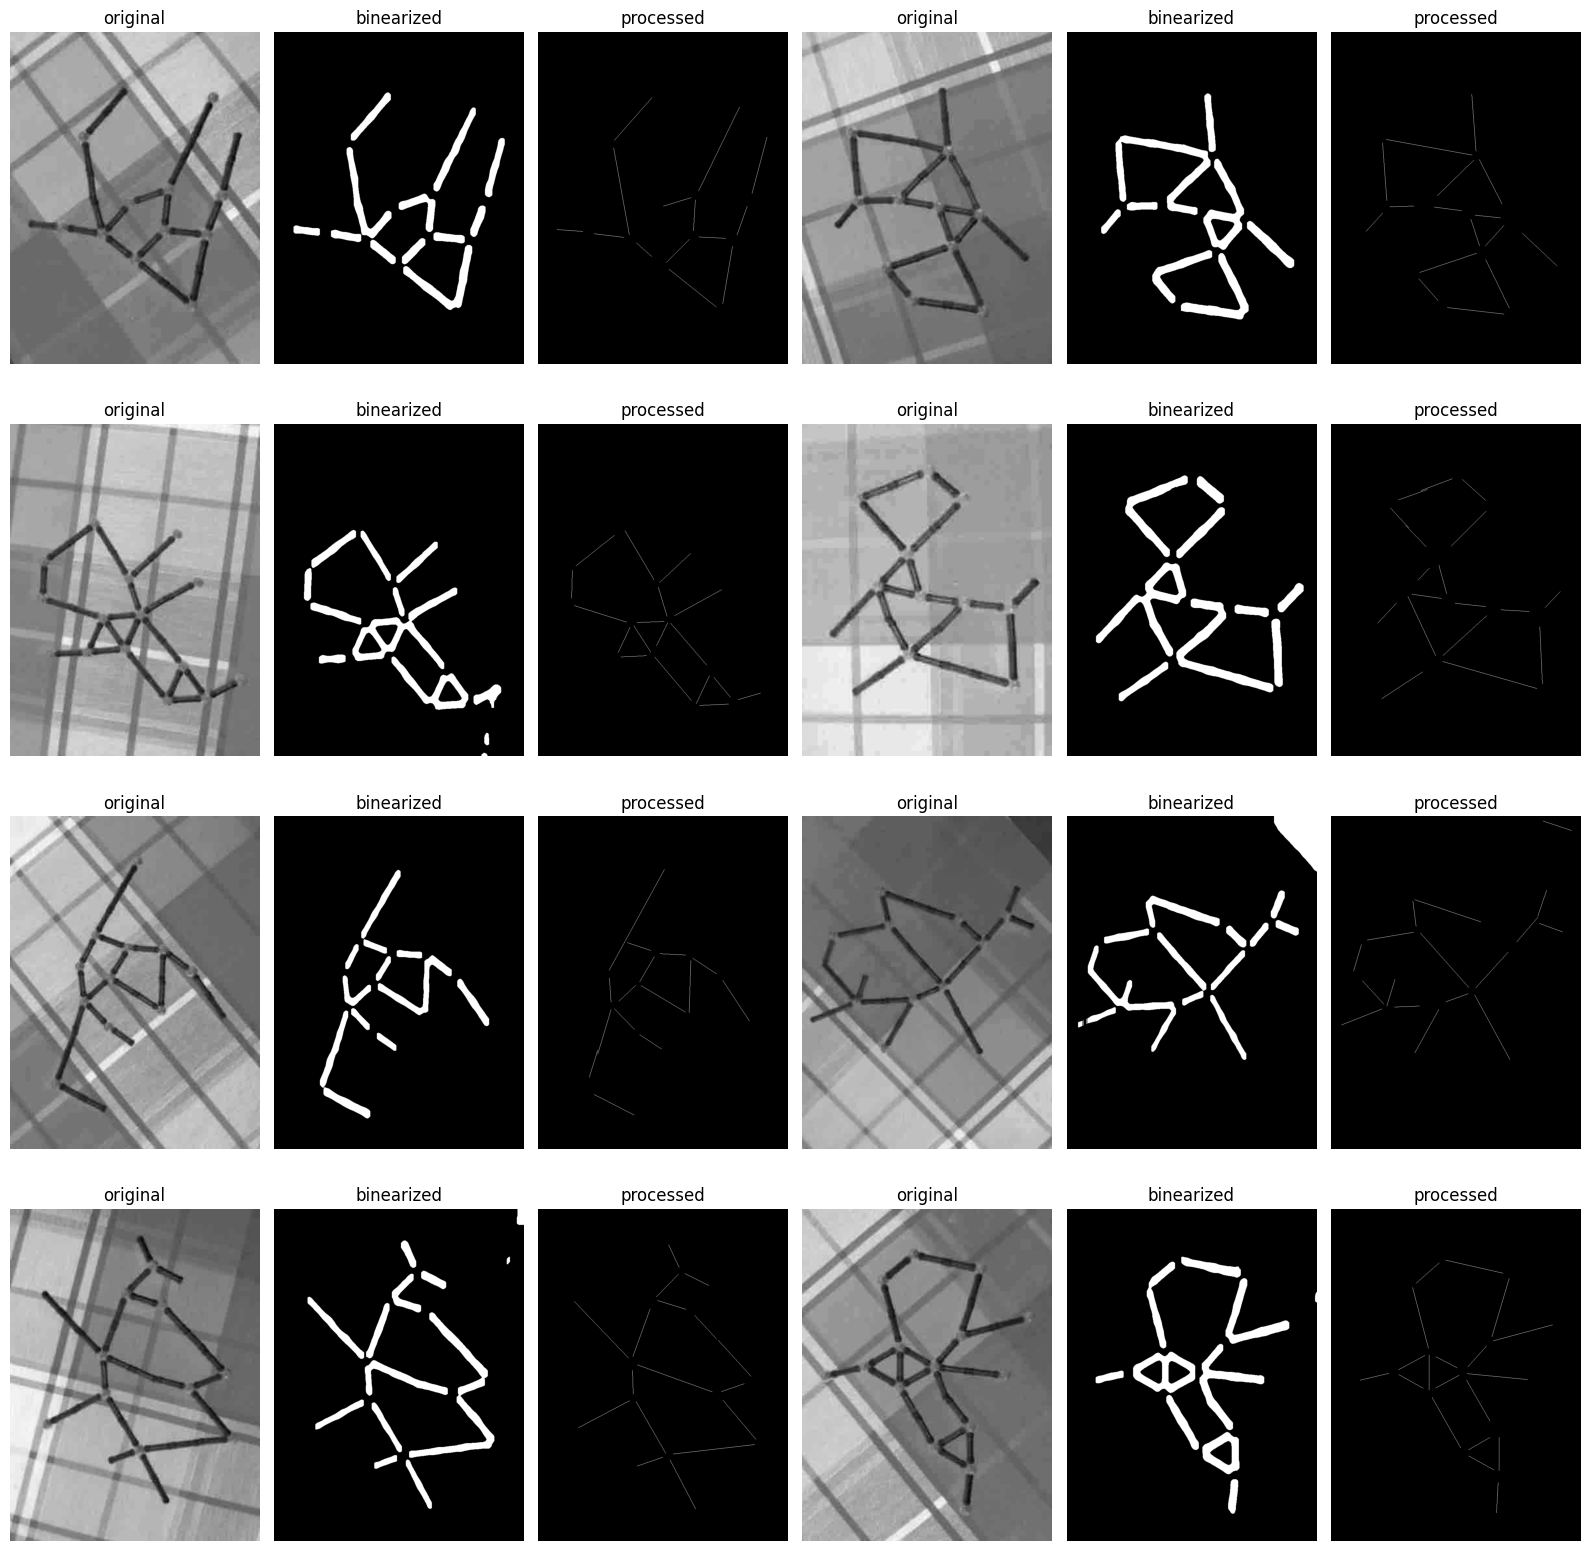

In [636]:
fig, axes = plt.subplots(len(colored_idxs) // 2, 6, figsize=(16, 16))
axes = iter(axes.flatten())

for img in colored_idxs:
    image = cv2.imread(f'./images/{img}.jpg')
    img_fmt = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    image = cv2.split(img_fmt)[1]
    if image.shape[0] < image.shape[1]:
        image = image.T
    show(image, ax=next(axes), title='original')

    image = binearize_image(image)
    show(image, ax=next(axes), title='binearized')

    image = skeletonize(image).astype(np.uint8)
    #show(image)

    image = detect_lines(image, threshold=20, minLineLength=40, maxLineGap=30)
    #show(image)
    image = approximate_lines(image, curvature_thres=0.05)
    #show(image)
    
    image = detect_lines(image, threshold=20, minLineLength=30, maxLineGap=30)
    #show(image)
    image = approximate_lines(image, curvature_thres=0.05)
    #show(image)

    image = detect_lines(image, threshold=20, minLineLength=20, maxLineGap=30)
    #show(image)
    image = approximate_lines(image, curvature_thres=0.01)
    show(image, ax=next(axes), title='processed')
plt.tight_layout()
plt.show()